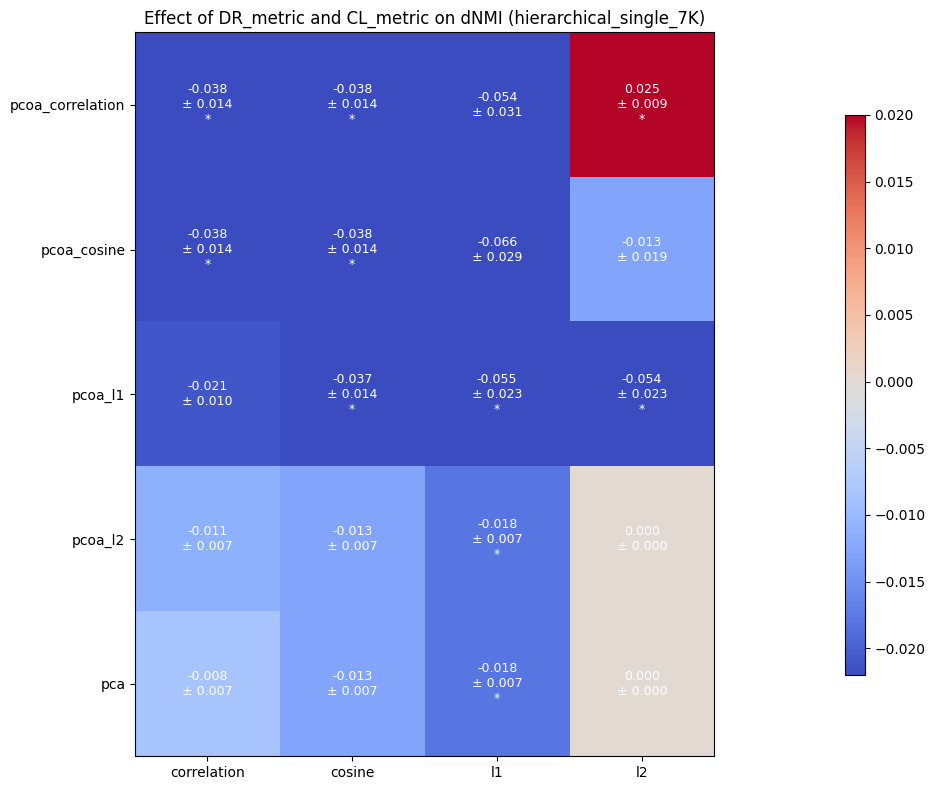

mean_metric                                 std_error  \
alg_metric       correlation    cosine        l1        l2 correlation   
rd_metric                                                                
pcoa_correlation   -0.037668 -0.037611 -0.053929  0.024816    0.014252   
pcoa_cosine        -0.037606 -0.037526 -0.065610 -0.012701    0.014262   
pcoa_l1            -0.020899 -0.037282 -0.054556 -0.054398    0.010350   
pcoa_l2            -0.011239 -0.012683 -0.017891  0.000000    0.007027   
pca                -0.008299 -0.012683 -0.017891  0.000000    0.007473   

                                                
alg_metric          cosine        l1        l2  
rd_metric                                       
pcoa_correlation  0.014257  0.030736  0.008827  
pcoa_cosine       0.014273  0.028876  0.018941  
pcoa_l1           0.014335  0.022930  0.022937  
pcoa_l2           0.006767  0.006991  0.000000  
pca               0.006767  0.006991  0.000000

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_1samp
from matplotlib.colors import Normalize
from statsmodels.stats.multitest import fdrcorrection

def preprocess_data(data):
    """Preprocess the data to calculate differences from the baseline metrics."""
    # index score of baseline (PCA + KNN-L2)
    baseline_rows = data[(data['rd_metric'] == 'pca') & (data['alg_metric'] == 'l2')]
    baseline_rows = baseline_rows[['dataset', 'NMI', 'ARI', 'FM']].copy()
    baseline_rows = baseline_rows.drop_duplicates(subset=['dataset'], keep='first')
    baseline_rows.rename(columns={'NMI': 'base_NMI', 'ARI': 'base_ARI', 'FM': 'base_FM'}, inplace=True)
    
    # Merge the baseline data back to the original dataframe on the 'dataset' column
    data = pd.merge(data, baseline_rows, on='dataset', how='left')
    data = data[data['dataset'] != 'TMS_facs_30K.h5ad']
    
    # Calculate the difference columns
    data['dNMI'] = data['NMI'] - data['base_NMI']
    data['dARI'] = data['ARI'] - data['base_ARI']
    data['dFM'] = data['FM'] - data['base_FM']
    
    return data

def calculate_stats(data, metric, alg='dbscan'):
    """ Calculate mean and standard error for a given metric grouped by rd_metric and alg_metric. """
    filtered_data = data[data['algorithm'] == alg]
    stats = filtered_data.groupby(["rd_metric", "alg_metric"]).agg(
        mean_metric=(metric, 'mean'),
        std_error=(metric, lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
    ).unstack(level='alg_metric')
    return stats

def perform_ttests(data, metric, mean_data):
    """ Perform t-tests for each combination of rd_metric and alg_metric against a null hypothesis of no change. """
    p_values = pd.DataFrame(index=mean_data.index, columns=mean_data.columns)
    for rd_metric in mean_data.index:
        for alg_metric in mean_data.columns:
            sample_data = data[(data['rd_metric'] == rd_metric) & (data['alg_metric'] == alg_metric)][metric]
            if len(sample_data) > 1:  # Ensure there is enough data to perform the t-test
                t_stat, p_val = ttest_1samp(sample_data.dropna(), 0)
                p_values.loc[rd_metric, alg_metric] = p_val
            else:
                p_values.loc[rd_metric, alg_metric] = np.nan
    
    # Convert p_values to numeric, coercing errors to NaN
    p_values = p_values.apply(pd.to_numeric, errors='coerce')
    
    # Apply FDR correction
    p_values_flat = p_values.values.flatten()
    non_nan_indices = ~np.isnan(p_values_flat)
    p_values_corrected = np.full_like(p_values_flat, np.nan)
    p_values_corrected[non_nan_indices] = fdrcorrection(p_values_flat[non_nan_indices])[1]
    p_values = pd.DataFrame(p_values_corrected.reshape(p_values.shape), index=p_values.index, columns=p_values.columns)
    
    return p_values

def create_heatmap(stats, p_values, title, vmin=None, vmax=None, cmap="coolwarm"):
    """ Create a heatmap with mean, standard error and significance annotations. """
    mean_data = stats['mean_metric']
    std_error_data = stats['std_error']
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Normalize with specified vmin and vmax
    norm = Normalize(vmin=vmin if vmin is not None else mean_data.min().min(), 
                     vmax=vmax if vmax is not None else mean_data.max().max())
    
    c = ax.imshow(mean_data, cmap=cmap, norm=norm)
    ax.set_xticks(np.arange(len(mean_data.columns)))
    ax.set_yticks(np.arange(len(mean_data.index)))
    ax.set_xticklabels(mean_data.columns)
    ax.set_yticklabels(mean_data.index)
    ax.set_title(title)
    
    for (i, j), val in np.ndenumerate(mean_data):
        rd_metric = mean_data.index[i]
        alg_metric = mean_data.columns[j]
        text = f"{val:.3f}\n± {std_error_data.loc[rd_metric, alg_metric]:.3f}"
        if p_values.loc[rd_metric, alg_metric] < 0.05:
            text += "\n*"
        ax.text(j, i, text, ha='center', va='center', color='white', fontsize=9)
    
    plt.tight_layout()
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(c, cax=cbar_ax)
    plt.show()

def sort_stats(stats):
    """ Sort the stats dataframe to place the 'pca' row at the bottom. """
    sorted_index = [index for index in stats.index if index != 'pca'] + ['pca']
    sorted_stats = stats.loc[sorted_index]
    return sorted_stats

df = pd.read_csv('results_hierarchical_single_0701_7K_DR.csv')
df['alg_metric'] = df['alg_metric'].apply(lambda x: 'l1' if x == 'L1' else x)
df['alg_metric'] = df['alg_metric'].apply(lambda x: 'l2' if x == 'L2' else x)
df['alg_metric'] = df['alg_metric'].apply(lambda x: 'cosine' if x == 'cos' else x)
df['alg_metric'] = df['alg_metric'].apply(lambda x: 'correlation' if x == 'pearson' else x)

vmin = 0.02  # Example minimum value for color range
vmax = -0.02  # Example maximum value for color range
cmap = "coolwarm"  # Example colormap

# Example usage
data = df  # replace with your DataFrame
corrected_merged_data = preprocess_data(data)
metric = 'dNMI'
stats = calculate_stats(corrected_merged_data, metric, alg='hierarchical')
stats = sort_stats(stats)
p_values = perform_ttests(corrected_merged_data, metric, stats['mean_metric'])
create_heatmap(stats, p_values, f"Effect of DR_metric and CL_metric on {metric} (hierarchical_single_7K)", vmin=vmin, vmax=vmax, cmap=cmap)
stats

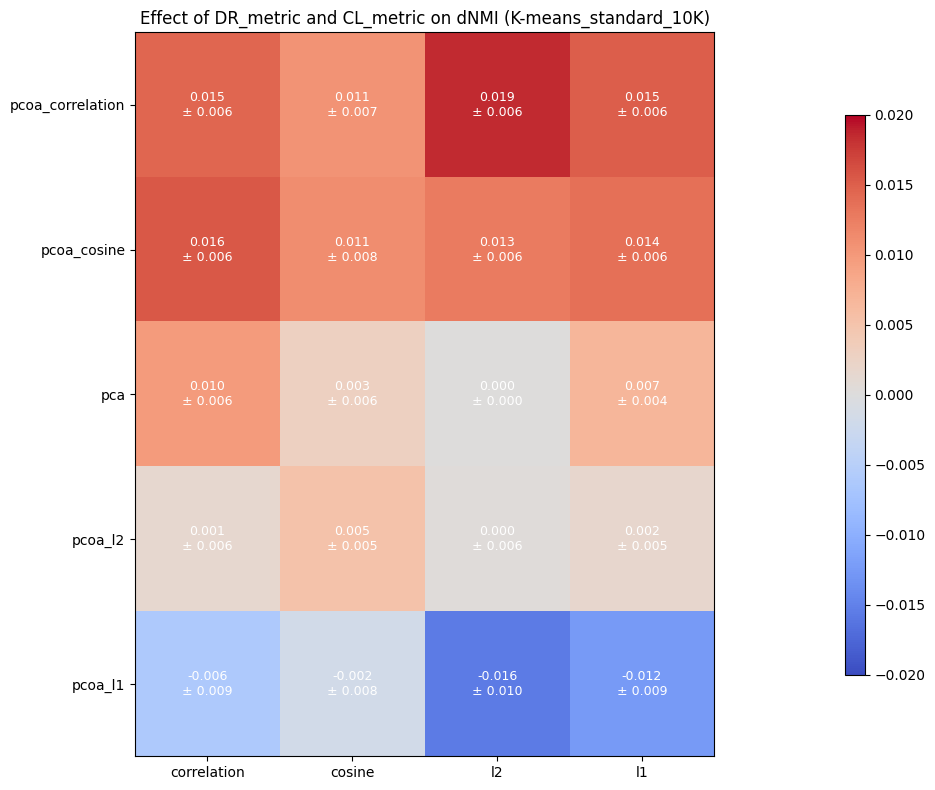

In [9]:
def preprocess_data(data):
    """Preprocess the data to calculate differences from the baseline metrics."""
    # index score of baseline (PCA + KNN-L2)
    baseline_rows = data[(data['rd_metric'] == 'pca') & (data['alg_metric'] == 'l2')]
    baseline_rows = baseline_rows[['dataset', 'NMI', 'ARI', 'FM']].copy()
    baseline_rows = baseline_rows.drop_duplicates(subset=['dataset'], keep='first')
    baseline_rows.rename(columns={'NMI': 'base_NMI', 'ARI': 'base_ARI', 'FM': 'base_FM'}, inplace=True)
    
    # Merge the baseline data back to the original dataframe on the 'dataset' column
    data = pd.merge(data, baseline_rows, on='dataset', how='left')
    data = data[data['dataset'] != 'TMS_facs_30K.h5ad']
    
    # Calculate the difference columns
    data['dNMI'] = data['NMI'] - data['base_NMI']
    data['dARI'] = data['ARI'] - data['base_ARI']
    data['dFM'] = data['FM'] - data['base_FM']
    
    return data

def calculate_stats(data, metric, alg='dbscan'):
    """ Calculate mean and standard error for a given metric grouped by rd_metric and alg_metric. """
    filtered_data = data[data['algorithm'] == alg]
    stats = filtered_data.groupby(["rd_metric", "alg_metric"]).agg(
        mean_metric=(metric, 'mean'),
        std_error=(metric, lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
    ).unstack(level='alg_metric')
    return stats

def perform_ttests(data, metric, mean_data):
    """ Perform t-tests for each combination of rd_metric and alg_metric against a null hypothesis of no change. """
    p_values = pd.DataFrame(index=mean_data.index, columns=mean_data.columns)
    for rd_metric in mean_data.index:
        for alg_metric in mean_data.columns:
            sample_data = data[(data['rd_metric'] == rd_metric) & (data['alg_metric'] == alg_metric)][metric]
            if len(sample_data) > 1:  # Ensure there is enough data to perform the t-test
                t_stat, p_val = ttest_1samp(sample_data.dropna(), 0)
                p_values.loc[rd_metric, alg_metric] = p_val
            else:
                p_values.loc[rd_metric, alg_metric] = np.nan
    
    # Convert p_values to numeric, coercing errors to NaN
    p_values = p_values.apply(pd.to_numeric, errors='coerce')
    
    # Apply FDR correction
    p_values_flat = p_values.values.flatten()
    non_nan_indices = ~np.isnan(p_values_flat)
    p_values_corrected = np.full_like(p_values_flat, np.nan)
    p_values_corrected[non_nan_indices] = fdrcorrection(p_values_flat[non_nan_indices])[1]
    p_values = pd.DataFrame(p_values_corrected.reshape(p_values.shape), index=p_values.index, columns=p_values.columns)
    
    return p_values

def create_heatmap(stats, p_values, title, x_order, y_order, vmin=None, vmax=None, cmap="coolwarm"):
    """ Create a heatmap with mean, standard error and significance annotations. """
    mean_data = stats['mean_metric'].reindex(index=y_order, columns=x_order)
    std_error_data = stats['std_error'].reindex(index=y_order, columns=x_order)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Normalize with specified vmin and vmax
    norm = Normalize(vmin=vmin if vmin is not None else mean_data.min().min(), 
                     vmax=vmax if vmax is not None else mean_data.max().max())
    
    c = ax.imshow(mean_data, cmap=cmap, norm=norm)
    ax.set_xticks(np.arange(len(mean_data.columns)))
    ax.set_yticks(np.arange(len(mean_data.index)))
    ax.set_xticklabels(mean_data.columns)
    ax.set_yticklabels(mean_data.index)
    ax.set_title(title)
    
    for (i, j), val in np.ndenumerate(mean_data):
        rd_metric = mean_data.index[i]
        alg_metric = mean_data.columns[j]
        text = f"{val:.3f}\n± {std_error_data.loc[rd_metric, alg_metric]:.3f}"
        if p_values.loc[rd_metric, alg_metric] < 0.05:
            text += "\n*"
        ax.text(j, i, text, ha='center', va='center', color='white', fontsize=9)
    
    plt.tight_layout()
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(c, cax=cbar_ax)
    plt.show()

def sort_stats(stats):
    """ Sort the stats dataframe to place the 'pca' row at the bottom. """
    sorted_index = [index for index in stats.index if index != 'pca'] + ['pca']
    sorted_stats = stats.loc[sorted_index]
    return sorted_stats

df = pd.read_csv('results_kmeans_standard_0701_10K_DR.csv')
df['alg_metric'] = df['alg_metric'].apply(lambda x: 'l1' if x == 'L1' else x)
df['alg_metric'] = df['alg_metric'].apply(lambda x: 'l2' if x == 'L2' else x)
df['alg_metric'] = df['alg_metric'].apply(lambda x: 'cosine' if x == 'cos' else x)
df['alg_metric'] = df['alg_metric'].apply(lambda x: 'correlation' if x == 'pearson' else x)

# Define the desired order for the x-axis and y-axis
x_order = ['correlation', 'cosine', 'l2', 'l1']
y_order = ['pcoa_correlation', 'pcoa_cosine', 'pca', 'pcoa_l2', 'pcoa_l1']  # Example order, adjust as needed

vmin = -0.02  # Example minimum value for color range
vmax = 0.02  # Example maximum value for color range
cmap = "coolwarm"  # Example colormap

# Example usage
data = df  # replace with your DataFrame
corrected_merged_data = preprocess_data(data)
metric = 'dNMI'
stats = calculate_stats(corrected_merged_data, metric, alg='hierarchical')
stats = sort_stats(stats)
p_values = perform_ttests(corrected_merged_data, metric, stats['mean_metric'])
create_heatmap(stats, p_values, f"Effect of DR_metric and CL_metric on {metric} (K-means_standard_10K)", x_order, y_order, vmin=vmin, vmax=vmax, cmap=cmap)





/tmp/ipykernel_20113/3641176118.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



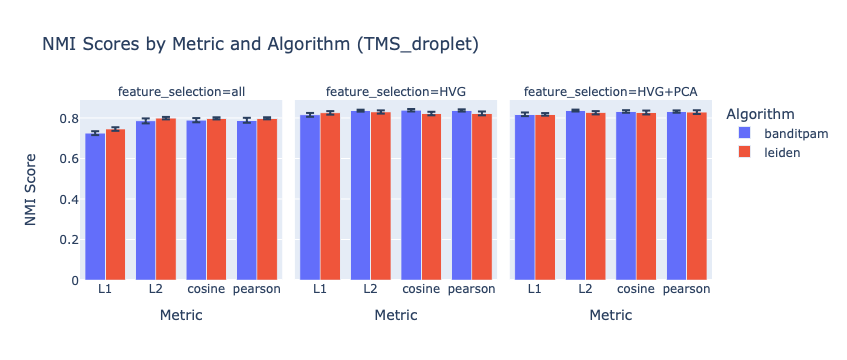

In [77]:
import plotly.express as px
import pandas as pd
import numpy as np

result = pd.read_csv(f"results_TMS_droplet_0303.csv")

result['metric'] = result['metric'].apply(lambda x: 'L1' if x == 'l1' else x)
result['metric'] = result['metric'].apply(lambda x: 'L2' if x == 'l2' else x)
result['metric'] = result['metric'].apply(lambda x: 'cosine' if x == 'cos' else x)
result['metric'] = result['metric'].apply(lambda x: 'pearson' if x == 'correlation' else x)

# Make sure the feature_selection in the desired order
result['feature_selection'] = pd.Categorical(result['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)
def calculate_stats(df):
    df_stats = df.groupby(['algorithm', 'feature_selection', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    # Calculate the t-score for 95% confidence interval and df_stats['n'] - 1 degrees of freedom
    df_stats['t_score'] = df_stats['n'].apply(lambda x: t.ppf(0.975, x-1))
    df_stats['ci_95'] = df_stats['t_score'] * df_stats['sem_NMI']
    return df_stats

result = calculate_stats(result)

# Now update the Plotly figure to use the CI for error bars
fig = px.bar(
    result,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='algorithm',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Scores by Metric and Algorithm (TMS_droplet)',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Algorithm',
    #yaxis_range=[0.2,1]
)

# Show the figure
fig.show()

/tmp/ipykernel_51455/3261633851.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_stats = df.groupby(['algorithm', 'feature_selection', 'metric']).agg(
/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(required_grouper, sort=False)  # skip one_group groupers


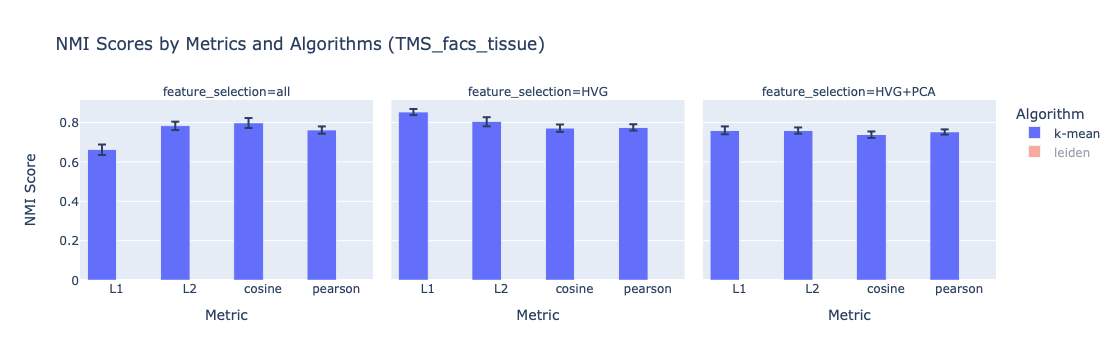

In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
from scipy.stats import t


result = pd.read_csv(f"results_TMS_facs_tissue_0411.csv")

metric_map = {'l1': 'L1', 'l2': 'L2', 'cos': 'cosine', 'correlation': 'pearson', 
              'l1_distance': 'L1', 'euclidean_distance': 'L2', 'cosine_distance': 'cosine', 'pearson_distance': 'pearson'}
result['metric'] = result['metric'].map(metric_map).fillna(result['metric'])

# Make sure the feature_selection in the desired order
result['feature_selection'] = pd.Categorical(result['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)

def calculate_stats(df):
    df_stats = df.groupby(['algorithm', 'feature_selection', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    # Calculate the t-score for 95% confidence interval and df_stats['n'] - 1 degrees of freedom
    df_stats['t_score'] = df_stats['n'].apply(lambda x: t.ppf(0.975, x-1))
    df_stats['ci_95'] = df_stats['t_score'] * df_stats['sem_NMI']
    return df_stats

result = calculate_stats(result)
# Now update the Plotly figure to use the CI for error bars
fig = px.bar(
    result,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='algorithm',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Scores by Metrics and Algorithms (TMS_facs_tissue)',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Algorithm',
    #yaxis_range=[0.2,1]
)

# Show the figure
fig.show()

/tmp/ipykernel_38732/855868445.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



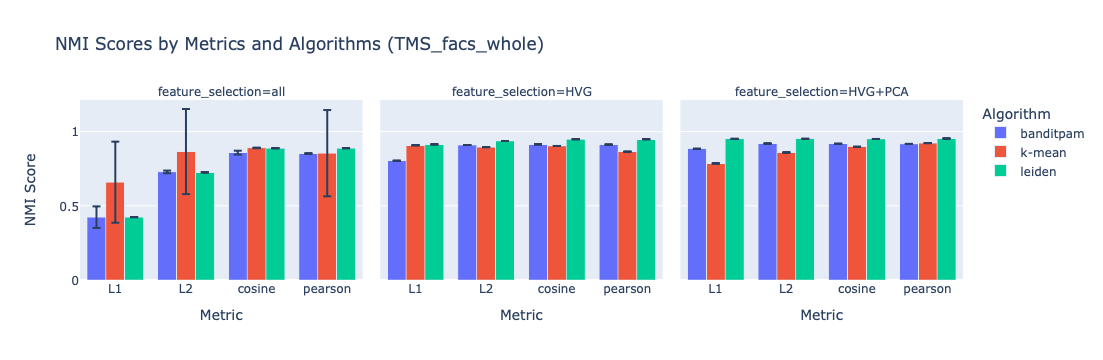

In [3]:
import plotly.express as px
import pandas as pd
import numpy as np
from scipy.stats import t


result = pd.read_csv(f"results_TMS_facs_whole_0410.csv")

metric_map = {'l1': 'L1', 'l2': 'L2', 'cos': 'cosine', 'correlation': 'pearson', 
              'l1_distance': 'L1', 'euclidean_distance': 'L2', 'cosine_distance': 'cosine', 'pearson_distance': 'pearson'}
result['metric'] = result['metric'].map(metric_map).fillna(result['metric'])

# Make sure the feature_selection in the desired order
result['feature_selection'] = pd.Categorical(result['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)

def calculate_stats(df):
    df_stats = df.groupby(['algorithm', 'feature_selection', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    # Calculate the t-score for 95% confidence interval and df_stats['n'] - 1 degrees of freedom
    df_stats['t_score'] = df_stats['n'].apply(lambda x: t.ppf(0.975, x-1))
    df_stats['ci_95'] = df_stats['t_score'] * df_stats['sem_NMI']
    return df_stats

result = calculate_stats(result)
# Now update the Plotly figure to use the CI for error bars
fig = px.bar(
    result,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='algorithm',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Scores by Metrics and Algorithms (TMS_facs_whole)',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Algorithm',
    #yaxis_range=[0.2,1]
)

# Show the figure
fig.show()

/tmp/ipykernel_38732/2821450732.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



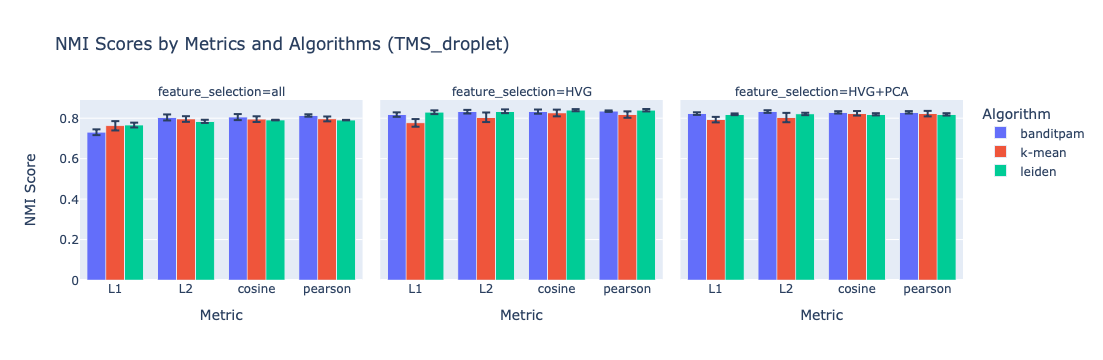

In [4]:
import plotly.express as px
import pandas as pd
import numpy as np
from scipy.stats import t


result = pd.read_csv(f"results_TMS_droplet_0410.csv")

metric_map = {'l1': 'L1', 'l2': 'L2', 'cos': 'cosine', 'correlation': 'pearson', 
              'l1_distance': 'L1', 'euclidean_distance': 'L2', 'cosine_distance': 'cosine', 'pearson_distance': 'pearson'}
result['metric'] = result['metric'].map(metric_map).fillna(result['metric'])

# Make sure the feature_selection in the desired order
result['feature_selection'] = pd.Categorical(result['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)

def calculate_stats(df):
    df_stats = df.groupby(['algorithm', 'feature_selection', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    # Calculate the t-score for 95% confidence interval and df_stats['n'] - 1 degrees of freedom
    df_stats['t_score'] = df_stats['n'].apply(lambda x: t.ppf(0.975, x-1))
    df_stats['ci_95'] = df_stats['t_score'] * df_stats['sem_NMI']
    return df_stats

result = calculate_stats(result)
# Now update the Plotly figure to use the CI for error bars
fig = px.bar(
    result,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='algorithm',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Scores by Metrics and Algorithms (TMS_droplet)',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Algorithm',
    #yaxis_range=[0.2,1]
)

# Show the figure
fig.show()

/tmp/ipykernel_38732/1205916616.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_stats = df.groupby(['algorithm', 'feature_selection', 'metric']).agg(
/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(required_grouper, sort=False)  # skip one_group groupers


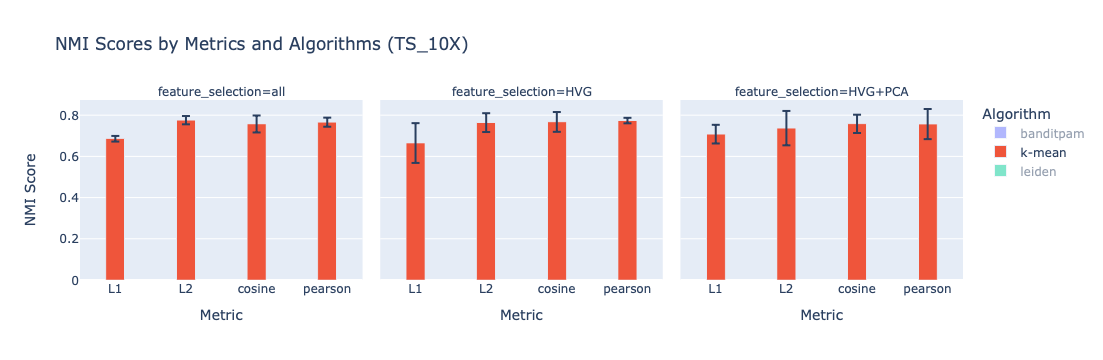

In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
from scipy.stats import t


result = pd.read_csv(f"results_TS_10X_0410.csv")

metric_map = {'l1': 'L1', 'l2': 'L2', 'cos': 'cosine', 'correlation': 'pearson', 
              'l1_distance': 'L1', 'euclidean_distance': 'L2', 'cosine_distance': 'cosine', 'pearson_distance': 'pearson'}
result['metric'] = result['metric'].map(metric_map).fillna(result['metric'])

# Make sure the feature_selection in the desired order
result['feature_selection'] = pd.Categorical(result['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)

def calculate_stats(df):
    df_stats = df.groupby(['algorithm', 'feature_selection', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    # Calculate the t-score for 95% confidence interval and df_stats['n'] - 1 degrees of freedom
    df_stats['t_score'] = df_stats['n'].apply(lambda x: t.ppf(0.975, x-1))
    df_stats['ci_95'] = df_stats['t_score'] * df_stats['sem_NMI']
    return df_stats

result = calculate_stats(result)
# Now update the Plotly figure to use the CI for error bars
fig = px.bar(
    result,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='algorithm',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Scores by Metrics and Algorithms (TS_10X)',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Algorithm',
    #yaxis_range=[0.2,1]
)

# Show the figure
fig.show()

/tmp/ipykernel_4076/683523212.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



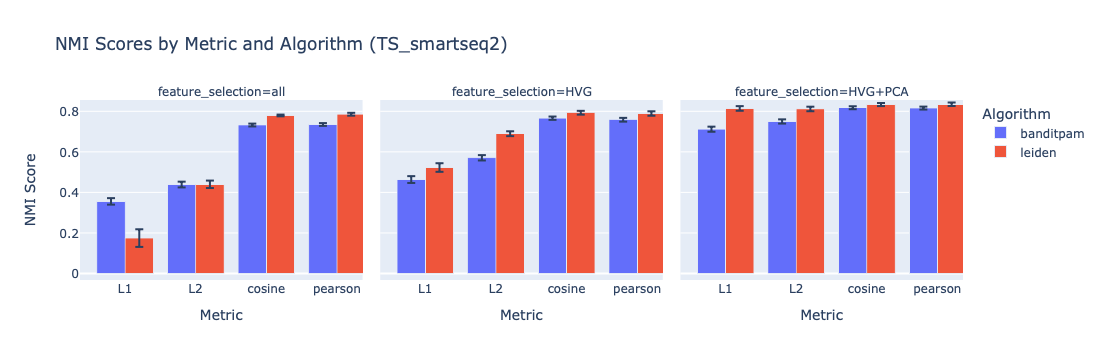

In [6]:
import plotly.express as px
import pandas as pd
import numpy as np
from scipy.stats import t

result = pd.read_csv(f"results_TS_smartseq2_0323.csv")

result['metric'] = result['metric'].apply(lambda x: 'L1' if x == 'l1' else x)
result['metric'] = result['metric'].apply(lambda x: 'L2' if x == 'l2' else x)
result['metric'] = result['metric'].apply(lambda x: 'cosine' if x == 'cos' else x)
result['metric'] = result['metric'].apply(lambda x: 'pearson' if x == 'correlation' else x)

# Make sure the feature_selection in the desired order
result['feature_selection'] = pd.Categorical(result['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)
def calculate_stats(df):
    df_stats = df.groupby(['algorithm', 'feature_selection', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    # Calculate the t-score for 95% confidence interval and df_stats['n'] - 1 degrees of freedom
    df_stats['t_score'] = df_stats['n'].apply(lambda x: t.ppf(0.975, x-1))
    df_stats['ci_95'] = df_stats['t_score'] * df_stats['sem_NMI']
    return df_stats

result = calculate_stats(result)

# Now update the Plotly figure to use the CI for error bars
fig = px.bar(
    result,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='algorithm',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Scores by Metric and Algorithm (TS_smartseq2)',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Algorithm',
    #yaxis_range=[0.2,1]
)

# Show the figure
fig.show()

/tmp/ipykernel_4076/613196113.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



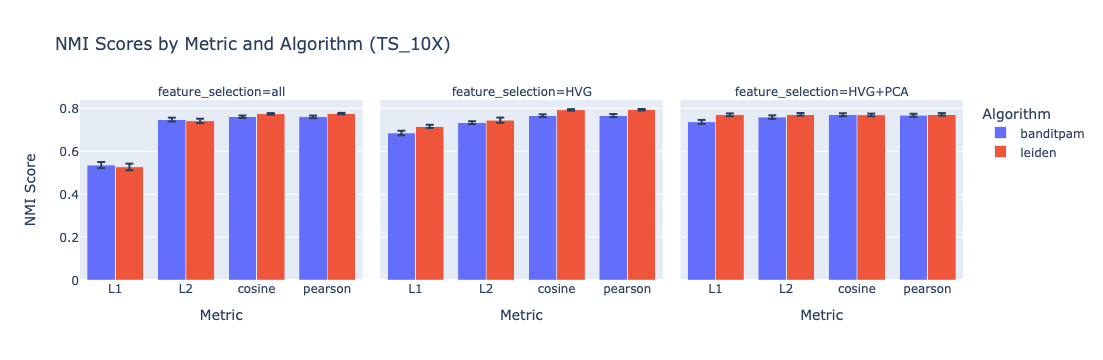

In [5]:
import plotly.express as px
import pandas as pd
import numpy as np
from scipy.stats import t

result = pd.read_csv(f"results_TS_10X_0323.csv")

result['metric'] = result['metric'].apply(lambda x: 'L1' if x == 'l1' else x)
result['metric'] = result['metric'].apply(lambda x: 'L2' if x == 'l2' else x)
result['metric'] = result['metric'].apply(lambda x: 'cosine' if x == 'cos' else x)
result['metric'] = result['metric'].apply(lambda x: 'pearson' if x == 'correlation' else x)

# Make sure the feature_selection in the desired order
result['feature_selection'] = pd.Categorical(result['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)
def calculate_stats(df):
    df_stats = df.groupby(['algorithm', 'feature_selection', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    # Calculate the t-score for 95% confidence interval and df_stats['n'] - 1 degrees of freedom
    df_stats['t_score'] = df_stats['n'].apply(lambda x: t.ppf(0.975, x-1))
    df_stats['ci_95'] = df_stats['t_score'] * df_stats['sem_NMI']
    return df_stats

result = calculate_stats(result)

# Now update the Plotly figure to use the CI for error bars
fig = px.bar(
    result,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='algorithm',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Scores by Metric and Algorithm (TS_10X)',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Algorithm',
    #yaxis_range=[0.2,1]
)

# Show the figure
fig.show()

    algorithm feature_selection   metric  mean_NMI   std_NMI  n   sem_NMI  \
0   banditpam               all       L1  0.440828  0.064162  5  0.028694   
1   banditpam               all       L2  0.723734  0.017017  5  0.007610   
2   banditpam               all   cosine  0.863290  0.020003  5  0.008946   
3   banditpam               all  pearson  0.868921  0.021198  5  0.009480   
4   banditpam               HVG       L1  0.776937  0.036366  5  0.016263   
5   banditpam               HVG       L2  0.870750  0.011437  5  0.005115   
6   banditpam               HVG   cosine  0.910250  0.004985  5  0.002229   
7   banditpam               HVG  pearson  0.911494  0.004685  5  0.002095   
8   banditpam           HVG+PCA       L1  0.898100  0.010628  5  0.004753   
9   banditpam           HVG+PCA       L2  0.917901  0.007564  5  0.003383   
10  banditpam           HVG+PCA   cosine  0.921765  0.003535  5  0.001581   
11  banditpam           HVG+PCA  pearson  0.920464  0.003413  5  0.001527   

/tmp/ipykernel_50023/3088106839.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



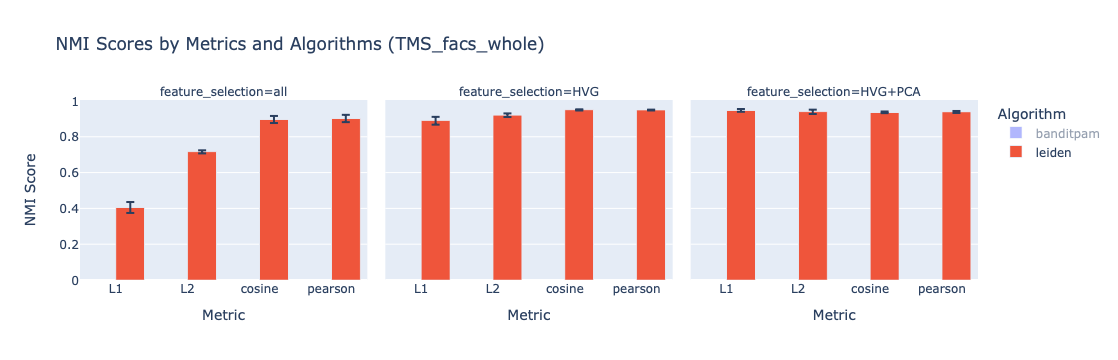

In [2]:
import plotly.express as px
import pandas as pd
import numpy as np
from scipy.stats import t


result = pd.read_csv(f"results_TMS_facs_whole_0319.csv")

metric_map = {'l1': 'L1', 'l2': 'L2', 'cos': 'cosine', 'correlation': 'pearson'}
result['metric'] = result['metric'].map(metric_map).fillna(result['metric'])
result = result[result['metric'] != 'clip']

# Make sure the feature_selection in the desired order
result['feature_selection'] = pd.Categorical(result['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)

def calculate_stats(df):
    df_stats = df.groupby(['algorithm', 'feature_selection', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    # Calculate the t-score for 95% confidence interval and df_stats['n'] - 1 degrees of freedom
    df_stats['t_score'] = df_stats['n'].apply(lambda x: t.ppf(0.975, x-1))
    df_stats['ci_95'] = df_stats['t_score'] * df_stats['sem_NMI']
    return df_stats

result = calculate_stats(result)
print(result)
# Now update the Plotly figure to use the CI for error bars
fig = px.bar(
    result,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='algorithm',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Scores by Metrics and Algorithms (TMS_facs_whole)',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Algorithm',
    #yaxis_range=[0.2,1]
)

# Show the figure
fig.show()

    algorithm feature_selection   metric  mean_NMI   std_NMI   n   sem_NMI  \
0   banditpam               all       L1  0.341110  0.067913  16  0.016978   
1   banditpam               all       L2  0.676261  0.026737  16  0.006684   
2   banditpam               all   cosine  0.854991  0.019176  16  0.004794   
3   banditpam               all  pearson  0.859111  0.021395  16  0.005349   
4   banditpam               HVG       L1  0.643133  0.078580  16  0.019645   
5   banditpam               HVG       L2  0.820900  0.018041  16  0.004510   
6   banditpam               HVG   cosine  0.907418  0.007942  16  0.001985   
7   banditpam               HVG  pearson  0.907144  0.007721  16  0.001930   
8   banditpam           HVG+PCA       L1  0.893113  0.006142  16  0.001536   
9   banditpam           HVG+PCA       L2  0.909665  0.006248  16  0.001562   
10  banditpam           HVG+PCA   cosine  0.913281  0.007220  16  0.001805   
11  banditpam           HVG+PCA  pearson  0.913545  0.007082  16

/tmp/ipykernel_14215/2481803769.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



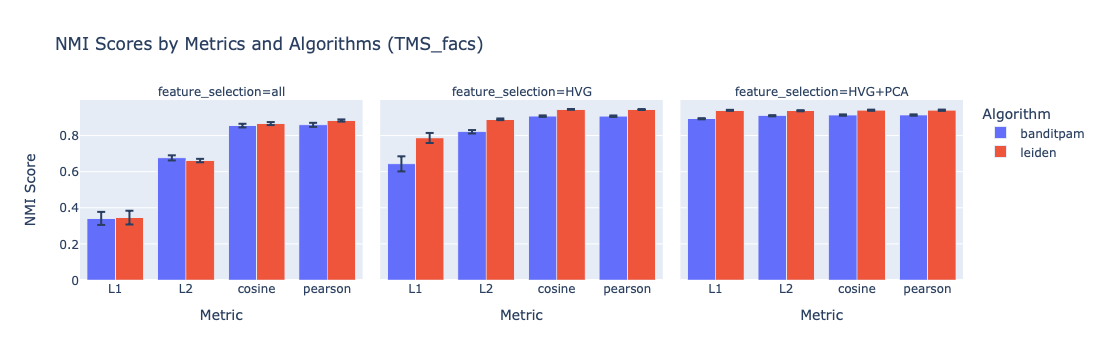

In [3]:
import plotly.express as px
import pandas as pd
import numpy as np
from scipy.stats import t


result = pd.read_csv(f"results_TMS_facs_0220.csv")

metric_map = {'l1': 'L1', 'l2': 'L2', 'cos': 'cosine', 'correlation': 'pearson'}
result['metric'] = result['metric'].map(metric_map).fillna(result['metric'])
result = result[result['metric'] != 'clip']

# Make sure the feature_selection in the desired order
result['feature_selection'] = pd.Categorical(result['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)

def calculate_stats(df):
    df_stats = df.groupby(['algorithm', 'feature_selection', 'metric']).agg(
        mean_NMI=('NMI(A)', 'mean'),
        std_NMI=('NMI(A)', 'std'),
        n=('NMI(A)', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    # Calculate the t-score for 95% confidence interval and df_stats['n'] - 1 degrees of freedom
    df_stats['t_score'] = df_stats['n'].apply(lambda x: t.ppf(0.975, x-1))
    df_stats['ci_95'] = df_stats['t_score'] * df_stats['sem_NMI']
    return df_stats

result = calculate_stats(result)
print(result)
# Now update the Plotly figure to use the CI for error bars
fig = px.bar(
    result,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='algorithm',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Scores by Metrics and Algorithms (TMS_facs)',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Algorithm',
    #yaxis_range=[0.2,1]
)

# Show the figure
fig.show()

/tmp/ipykernel_51455/1317770404.py:35: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_51455/1317770404.py:35: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



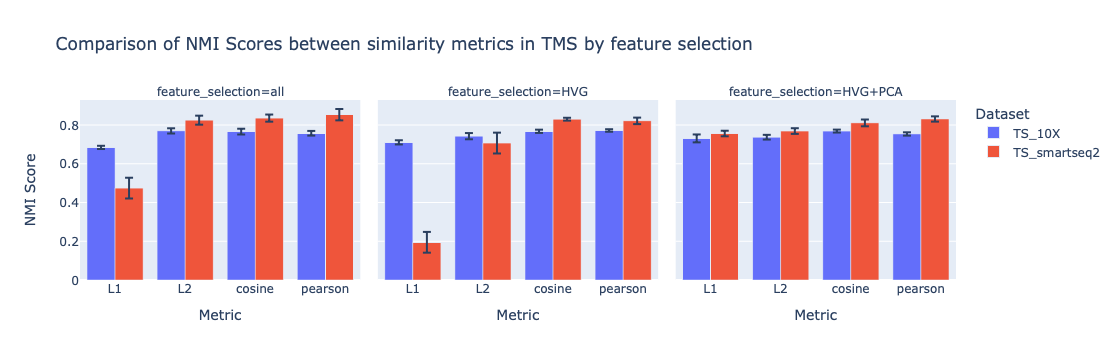

In [23]:
import plotly.express as px
import pandas as pd
import numpy as np

droplet = pd.read_csv(f"results_TS_10X_0411.csv")
facs = pd.read_csv(f"results_TS_smartseq2_0411.csv")

facs['metric'] = facs['metric'].apply(lambda x: 'L1' if x == 'l1_distance' else x)
facs['metric'] = facs['metric'].apply(lambda x: 'L2' if x == 'euclidean_distance' else x)
facs['metric'] = facs['metric'].apply(lambda x: 'cosine' if x == 'cosine_distance' else x)
facs['metric'] = facs['metric'].apply(lambda x: 'pearson' if x == 'pearson_distance' else x)
facs = facs[facs['algorithm'] == 'k-mean']
facs['feature_selection'] = pd.Categorical(facs['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)

droplet['metric'] = droplet['metric'].apply(lambda x: 'L1' if x == 'l1_distance' else x)
droplet['metric'] = droplet['metric'].apply(lambda x: 'L2' if x == 'euclidean_distance' else x)
droplet['metric'] = droplet['metric'].apply(lambda x: 'cosine' if x == 'cosine_distance' else x)
droplet['metric'] = droplet['metric'].apply(lambda x: 'pearson' if x == 'pearson_distance' else x)
droplet = droplet[droplet['algorithm'] == 'k-mean']
droplet['feature_selection'] = pd.Categorical(droplet['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)


# Normalize metric names
metric_map = {'l1': 'L1', 'l2': 'L2', 'cos': 'cosine', 'correlation': 'pearson'}
droplet['metric'] = droplet['metric'].map(metric_map).fillna(droplet['metric'])
facs['metric'] = facs['metric'].map(metric_map).fillna(facs['metric'])
facs = facs[facs['metric'] != 'clip']

# Define a function to calculate mean, standard deviation, and 95% confidence interval
def calculate_stats(df, dataset_name):
    df_stats = df.groupby(['feature_selection', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    df_stats['ci_95'] = 1.96 * df_stats['sem_NMI']
    df_stats['dataset'] = dataset_name
    return df_stats

# Calculate statistics for each dataset
droplet_stats = calculate_stats(droplet, 'TS_10X')
facs_stats = calculate_stats(facs, 'TS_smartseq2')

# Combine the two datasets for comparison
combined_stats = pd.concat([droplet_stats, facs_stats], axis=0)
# Now create the Plotly figure to compare datasets, split by algorithm
fig = px.bar(
    combined_stats,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='dataset',
    facet_col='feature_selection',  # Assumes there is an 'algorithm' column for faceting
    barmode='group',
    title='Comparison of NMI Scores between similarity metrics in TMS by feature selection',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Dataset',
)

# Show the figure
fig.show()

/tmp/ipykernel_51455/1218479126.py:35: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_51455/1218479126.py:35: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



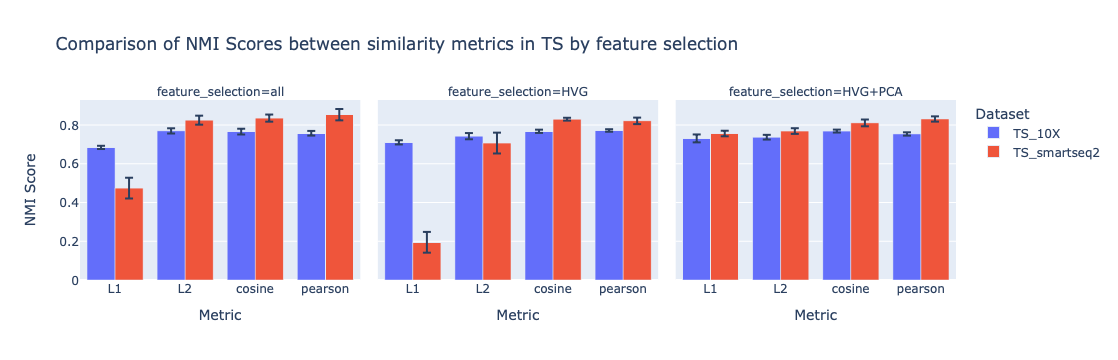

In [25]:
import plotly.express as px
import pandas as pd
import numpy as np

droplet = pd.read_csv(f"results_TS_10X_0411.csv")
facs = pd.read_csv(f"results_TS_smartseq2_0411.csv")

facs['metric'] = facs['metric'].apply(lambda x: 'L1' if x == 'l1_distance' else x)
facs['metric'] = facs['metric'].apply(lambda x: 'L2' if x == 'euclidean_distance' else x)
facs['metric'] = facs['metric'].apply(lambda x: 'cosine' if x == 'cosine_distance' else x)
facs['metric'] = facs['metric'].apply(lambda x: 'pearson' if x == 'pearson_distance' else x)
facs = facs[facs['algorithm'] == 'k-mean']
facs['feature_selection'] = pd.Categorical(facs['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)

droplet['metric'] = droplet['metric'].apply(lambda x: 'L1' if x == 'l1_distance' else x)
droplet['metric'] = droplet['metric'].apply(lambda x: 'L2' if x == 'euclidean_distance' else x)
droplet['metric'] = droplet['metric'].apply(lambda x: 'cosine' if x == 'cosine_distance' else x)
droplet['metric'] = droplet['metric'].apply(lambda x: 'pearson' if x == 'pearson_distance' else x)
droplet = droplet[droplet['algorithm'] == 'k-mean']
droplet['feature_selection'] = pd.Categorical(droplet['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)


# Normalize metric names
metric_map = {'l1': 'L1', 'l2': 'L2', 'cos': 'cosine', 'correlation': 'pearson'}
droplet['metric'] = droplet['metric'].map(metric_map).fillna(droplet['metric'])
facs['metric'] = facs['metric'].map(metric_map).fillna(facs['metric'])
facs = facs[facs['metric'] != 'clip']

# Define a function to calculate mean, standard deviation, and 95% confidence interval
def calculate_stats(df, dataset_name):
    df_stats = df.groupby(['feature_selection', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    df_stats['ci_95'] = 1.96 * df_stats['sem_NMI']
    df_stats['dataset'] = dataset_name
    return df_stats

# Calculate statistics for each dataset
droplet_stats = calculate_stats(droplet, 'TS_10X')
facs_stats = calculate_stats(facs, 'TS_smartseq2')

# Combine the two datasets for comparison
combined_stats = pd.concat([droplet_stats, facs_stats], axis=0)
# Now create the Plotly figure to compare datasets, split by algorithm
fig = px.bar(
    combined_stats,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='dataset',
    facet_col='feature_selection',  # Assumes there is an 'algorithm' column for faceting
    barmode='group',
    title='Comparison of NMI Scores between similarity metrics in TS by feature selection',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Dataset',
)

# Show the figure
fig.show()

/tmp/ipykernel_51455/361933531.py:34: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_51455/361933531.py:34: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



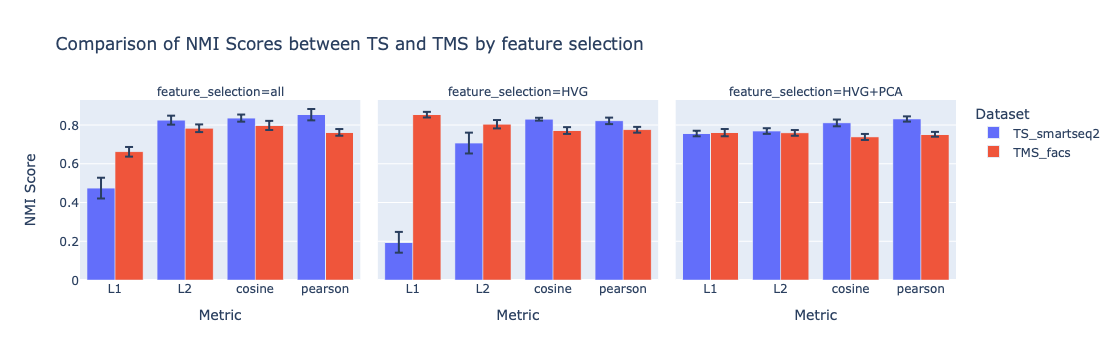

In [26]:
import plotly.express as px
import pandas as pd
import numpy as np

facs = pd.read_csv(f"results_TMS_facs_tissue_0411.csv")
droplet = pd.read_csv(f"results_TS_smartseq2_0411.csv")

facs['metric'] = facs['metric'].apply(lambda x: 'L1' if x == 'l1_distance' else x)
facs['metric'] = facs['metric'].apply(lambda x: 'L2' if x == 'euclidean_distance' else x)
facs['metric'] = facs['metric'].apply(lambda x: 'cosine' if x == 'cosine_distance' else x)
facs['metric'] = facs['metric'].apply(lambda x: 'pearson' if x == 'pearson_distance' else x)
facs = facs[facs['algorithm'] == 'k-mean']
facs['feature_selection'] = pd.Categorical(facs['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)

droplet['metric'] = droplet['metric'].apply(lambda x: 'L1' if x == 'l1_distance' else x)
droplet['metric'] = droplet['metric'].apply(lambda x: 'L2' if x == 'euclidean_distance' else x)
droplet['metric'] = droplet['metric'].apply(lambda x: 'cosine' if x == 'cosine_distance' else x)
droplet['metric'] = droplet['metric'].apply(lambda x: 'pearson' if x == 'pearson_distance' else x)
droplet = droplet[droplet['algorithm'] == 'k-mean']
droplet['feature_selection'] = pd.Categorical(droplet['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)

# Normalize metric names
metric_map = {'l1': 'L1', 'l2': 'L2', 'cos': 'cosine', 'correlation': 'pearson'}
droplet['metric'] = droplet['metric'].map(metric_map).fillna(droplet['metric'])
facs['metric'] = facs['metric'].map(metric_map).fillna(facs['metric'])
facs = facs[facs['metric'] != 'clip']

# Define a function to calculate mean, standard deviation, and 95% confidence interval
def calculate_stats(df, dataset_name):
    df_stats = df.groupby(['feature_selection', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    df_stats['ci_95'] = 1.96 * df_stats['sem_NMI']
    df_stats['dataset'] = dataset_name
    return df_stats

# Calculate statistics for each dataset
droplet_stats = calculate_stats(droplet, 'TS_smartseq2')
facs_stats = calculate_stats(facs, 'TMS_facs')

# Combine the two datasets for comparison
combined_stats = pd.concat([droplet_stats, facs_stats], axis=0)
# Now create the Plotly figure to compare datasets, split by algorithm
fig = px.bar(
    combined_stats,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='dataset',
    facet_col='feature_selection',  # Assumes there is an 'algorithm' column for faceting
    barmode='group',
    title='Comparison of NMI Scores between TS and TMS by feature selection',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Dataset',
)

# Show the figure
fig.show()

/tmp/ipykernel_51455/639864985.py:36: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_51455/639864985.py:36: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



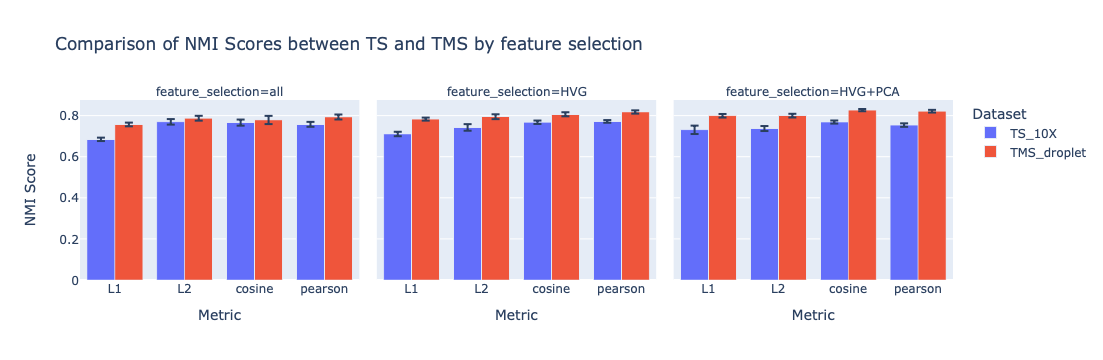

In [27]:
import plotly.express as px
import pandas as pd
import numpy as np

facs = pd.read_csv(f"results_TMS_droplet_0411.csv")
droplet = pd.read_csv(f"results_TS_10X_0411.csv")

facs['metric'] = facs['metric'].apply(lambda x: 'L1' if x == 'l1_distance' else x)
facs['metric'] = facs['metric'].apply(lambda x: 'L2' if x == 'euclidean_distance' else x)
facs['metric'] = facs['metric'].apply(lambda x: 'cosine' if x == 'cosine_distance' else x)
facs['metric'] = facs['metric'].apply(lambda x: 'pearson' if x == 'pearson_distance' else x)
facs = facs[facs['algorithm'] == 'k-mean']
facs['feature_selection'] = pd.Categorical(facs['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)

droplet['metric'] = droplet['metric'].apply(lambda x: 'L1' if x == 'l1_distance' else x)
droplet['metric'] = droplet['metric'].apply(lambda x: 'L2' if x == 'euclidean_distance' else x)
droplet['metric'] = droplet['metric'].apply(lambda x: 'cosine' if x == 'cosine_distance' else x)
droplet['metric'] = droplet['metric'].apply(lambda x: 'pearson' if x == 'pearson_distance' else x)
droplet = droplet[droplet['algorithm'] == 'k-mean']
droplet['feature_selection'] = pd.Categorical(droplet['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)



# Normalize metric names
metric_map = {'l1': 'L1', 'l2': 'L2', 'cos': 'cosine', 'correlation': 'pearson'}
droplet['metric'] = droplet['metric'].map(metric_map).fillna(droplet['metric'])
facs['metric'] = facs['metric'].map(metric_map).fillna(facs['metric'])
facs = facs[facs['metric'] != 'clip']

# Define a function to calculate mean, standard deviation, and 95% confidence interval
def calculate_stats(df, dataset_name):
    df_stats = df.groupby(['feature_selection', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    df_stats['ci_95'] = 1.96 * df_stats['sem_NMI']
    df_stats['dataset'] = dataset_name
    return df_stats

# Calculate statistics for each dataset
droplet_stats = calculate_stats(droplet, 'TS_10X')
facs_stats = calculate_stats(facs, 'TMS_droplet')

# Combine the two datasets for comparison
combined_stats = pd.concat([droplet_stats, facs_stats], axis=0)
# Now create the Plotly figure to compare datasets, split by algorithm
fig = px.bar(
    combined_stats,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='dataset',
    facet_col='feature_selection',  # Assumes there is an 'algorithm' column for faceting
    barmode='group',
    title='Comparison of NMI Scores between TS and TMS by feature selection',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Dataset',
)

# Show the figure
fig.show()

/tmp/ipykernel_51455/311519006.py:34: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_51455/311519006.py:34: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



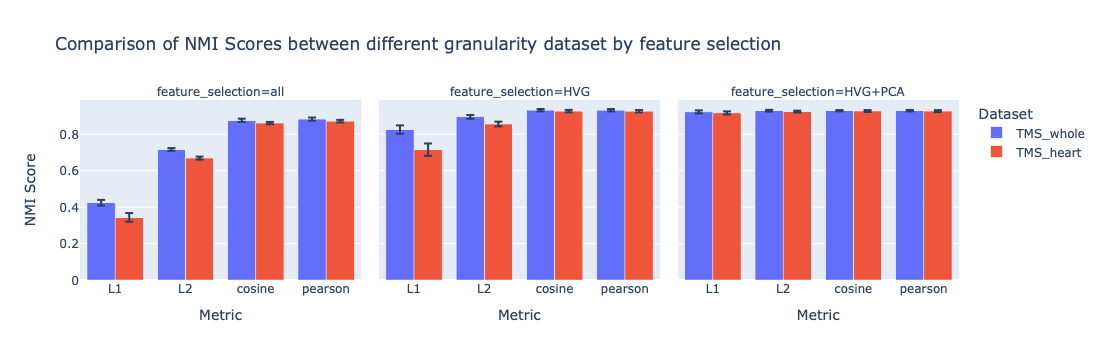

In [17]:
import plotly.express as px
import pandas as pd
import numpy as np

whole = pd.read_csv(f"results_TMS_facs_whole_0319.csv")
tissue = pd.read_csv(f"results_TMS_facs_0220.csv")

tissue['metric'] = tissue['metric'].apply(lambda x: 'L1' if x == 'l1' else x)
tissue['metric'] = tissue['metric'].apply(lambda x: 'L2' if x == 'l2' else x)
tissue['metric'] = tissue['metric'].apply(lambda x: 'cosine' if x == 'cos' else x)
tissue['metric'] = tissue['metric'].apply(lambda x: 'pearson' if x == 'correlation' else x)
tissue['NMI'] = tissue['NMI(A)']
tissue = tissue[tissue['metric'] != 'clip']
tissue['feature_selection'] = pd.Categorical(tissue['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)

whole['metric'] = whole['metric'].apply(lambda x: 'L1' if x == 'l1' else x)
whole['metric'] = whole['metric'].apply(lambda x: 'L2' if x == 'l2' else x)
whole['metric'] = whole['metric'].apply(lambda x: 'cosine' if x == 'cos' else x)
whole['metric'] = whole['metric'].apply(lambda x: 'pearson' if x == 'correlation' else x)
whole['feature_selection'] = pd.Categorical(whole['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)

# Normalize metric names
metric_map = {'l1': 'L1', 'l2': 'L2', 'cos': 'cosine', 'correlation': 'pearson'}
whole['metric'] = whole['metric'].map(metric_map).fillna(whole['metric'])
tissue['metric'] = tissue['metric'].map(metric_map).fillna(tissue['metric'])
tissue = tissue[tissue['metric'] != 'clip']

# Define a function to calculate mean, standard deviation, and 95% confidence interval
def calculate_stats(df, dataset_name):
    df_stats = df.groupby(['feature_selection', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    df_stats['ci_95'] = 1.96 * df_stats['sem_NMI']
    df_stats['dataset'] = dataset_name
    return df_stats

# Calculate statistics for each dataset
whole_stats = calculate_stats(whole, 'TMS_whole')
tissue_stats = calculate_stats(tissue, 'TMS_heart')

# Combine the two datasets for comparison
combined_stats = pd.concat([whole_stats, tissue_stats], axis=0)
# Now create the Plotly figure to compare datasets, split by algorithm
fig = px.bar(
    combined_stats,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='dataset',
    facet_col='feature_selection',  # Assumes there is an 'algorithm' column for faceting
    barmode='group',
    title='Comparison of NMI Scores between different granularity dataset by feature selection',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Dataset',
)

# Show the figure
fig.show()

/tmp/ipykernel_20113/3617261366.py:27: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



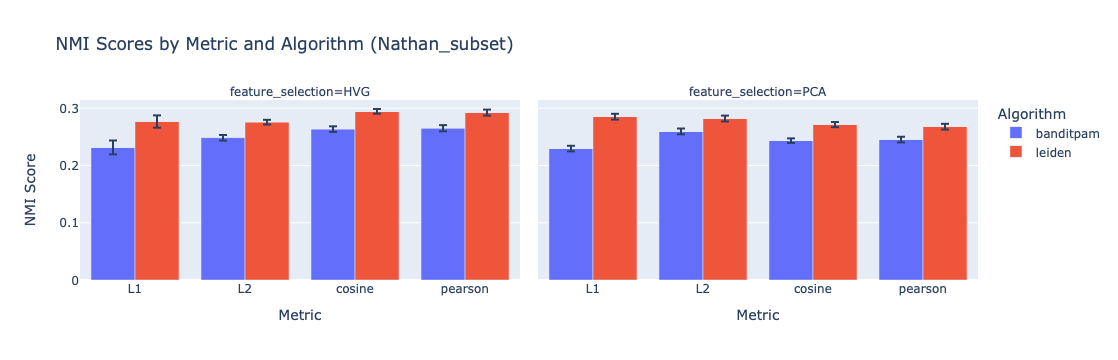

In [69]:
import plotly.express as px
import pandas as pd
import numpy as np
from scipy.stats import t

result = pd.read_csv(f"results_Nathan_subset_0304.csv")

result['metric'] = result['metric'].apply(lambda x: 'L1' if x == 'l1' else x)
result['metric'] = result['metric'].apply(lambda x: 'L2' if x == 'l2' else x)
result['metric'] = result['metric'].apply(lambda x: 'cosine' if x == 'cos' else x)
result['metric'] = result['metric'].apply(lambda x: 'pearson' if x == 'correlation' else x)
result = result[result['metric'] != 'clip']

# Normalize metric names
metric_map = {'l1': 'L1', 'l2': 'L2', 'cos': 'cosine', 'correlation': 'pearson'}
feature_map = {'all': 'HVG', 'PCA': 'PCA'}
result['metric'] = result['metric'].map(metric_map).fillna(result['metric'])
result['feature_selection'] = result['feature_selection'].map(feature_map).fillna(result['feature_selection'])

# Make sure the feature_selection in the desired order
result['feature_selection'] = pd.Categorical(result['feature_selection'], 
                                             categories=['HVG', 'PCA'], 
                                             ordered=True)

# Define a function to calculate mean, standard deviation, and 95% confidence interval
def calculate_stats(df):
    df_stats = df.groupby(['algorithm', 'feature_selection', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    # Calculate the t-score for 95% confidence interval and df_stats['n'] - 1 degrees of freedom
    df_stats['t_score'] = df_stats['n'].apply(lambda x: t.ppf(0.975, x-1))
    df_stats['ci_95'] = df_stats['t_score'] * df_stats['sem_NMI']
    return df_stats


# Calculate statistics for each dataset
result = calculate_stats(result)

# Now update the Plotly figure to use the CI for error bars
fig = px.bar(
    result,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='algorithm',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Scores by Metric and Algorithm (Nathan_subset)',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Algorithm',
    #yaxis_range=[0.2,1]
)

# Show the figure
fig.show()

   feature_selection  algorithm   metric  mean_NMI   std_NMI  n   sem_NMI  \
0                all  banditpam       L1  0.034254  0.011353  9  0.003784   
1                all  banditpam       L2  0.106494  0.044068  9  0.014689   
2                all  banditpam   cosine  0.136423  0.051909  9  0.017303   
3                all  banditpam  pearson  0.134106  0.050233  8  0.017760   
4                all     leiden       L1  0.053828  0.016665  9  0.005555   
5                all     leiden       L2  0.127009  0.043323  9  0.014441   
6                all     leiden   cosine  0.158837  0.036183  9  0.012061   
7                all     leiden  pearson  0.167030  0.037313  9  0.012438   
8                HVG  banditpam       L1  0.126955  0.019066  8  0.006741   
9                HVG  banditpam       L2  0.209853  0.012611  8  0.004459   
10               HVG  banditpam   cosine  0.232130  0.010023  8  0.003544   
11               HVG  banditpam  pearson  0.233048  0.009565  8  0.003382   

/tmp/ipykernel_20113/3282089078.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/yenhsian/miniconda3/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



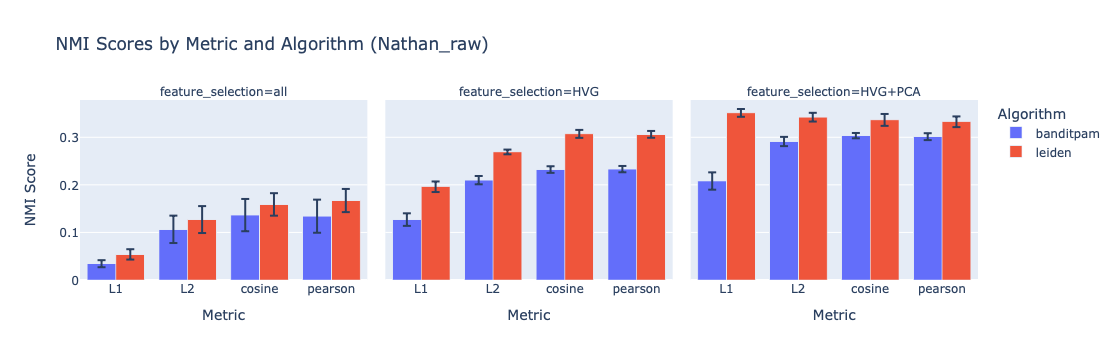

In [55]:
import plotly.express as px
import pandas as pd
import numpy as np

result = pd.read_csv(f"results_Nathan_raw_0303.csv")
result = result[result['metric'] != 'clip']

# Normalize metric names
metric_map = {'l1': 'L1', 'l2': 'L2', 'cos': 'cosine', 'correlation': 'pearson'}
result['metric'] = result['metric'].map(metric_map).fillna(result['metric'])

# Make sure the feature_selection in the desired order
result['feature_selection'] = pd.Categorical(result['feature_selection'], 
                                             categories=['all', 'HVG', 'HVG+PCA'], 
                                             ordered=True)

# Define a function to calculate mean, standard deviation, and 95% confidence interval
def calculate_stats(df):
    df_stats = df.groupby(['feature_selection','algorithm', 'metric']).agg(
        mean_NMI=('NMI', 'mean'),
        std_NMI=('NMI', 'std'),
        n=('NMI', 'count')
    ).reset_index()
    df_stats['sem_NMI'] = df_stats['std_NMI'] / np.sqrt(df_stats['n'])
    df_stats['ci_95'] = 1.96 * df_stats['sem_NMI']
    return df_stats

# Calculate statistics for each dataset
result = calculate_stats(result)
print(result)

# Now update the Plotly figure to use the CI for error bars
fig = px.bar(
    result,
    x='metric',
    y='mean_NMI',
    error_y='ci_95',
    color='algorithm',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Scores by Metric and Algorithm (Nathan_raw)',
    labels={'mean_NMI': 'Mean NMI', 'ci_95': '95% CI', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'ci_95']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Algorithm',
    #yaxis_range=[0.2,1]
)

# Show the figure
fig.show()

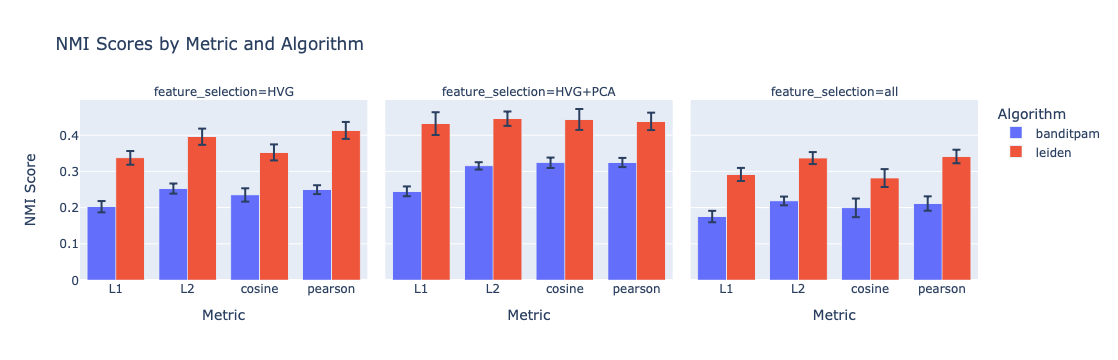

In [10]:
import plotly.express as px
import pandas as pd

# Assuming you have already loaded your data into 'result' DataFrame.
df1 = pd.read_csv(f"results_0229_1.csv")
df2 = pd.read_csv(f"results_0229.csv")
frames = [df1, df2]
result = pd.concat(frames)

result['metric'] = result['metric'].apply(lambda x: 'L1' if x == 'l1' else x)
result['metric'] = result['metric'].apply(lambda x: 'L2' if x == 'l2' else x)
result['metric'] = result['metric'].apply(lambda x: 'cosine' if x == 'cos' else x)
result['metric'] = result['metric'].apply(lambda x: 'pearson' if x == 'correlation' else x)

# Calculate mean and standard deviation for each metric and algorithm
mean_scores = result.groupby(['feature_selection', 'algorithm', 'metric'])['NMI'].mean().reset_index(name='mean_NMI')
std_scores = result.groupby(['feature_selection', 'algorithm', 'metric'])['NMI'].std().reset_index(name='std_NMI')

# Merge the mean and standard deviation into one DataFrame
filtered_scores = merged_scores[merged_scores['metric'] != 'clip']

# Now create the bar chart using the filtered DataFrame
fig = px.bar(
    filtered_scores,
    x='metric',
    y='mean_NMI',
    error_y='std_NMI',
    color='algorithm',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Scores by Metric and Algorithm',
    labels={'mean_NMI': 'Mean NMI', 'std_NMI': 'Standard Deviation', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'std_NMI']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Algorithm',
    #yaxis_range=[0.2,1]
)

# Show the figure
fig.show()

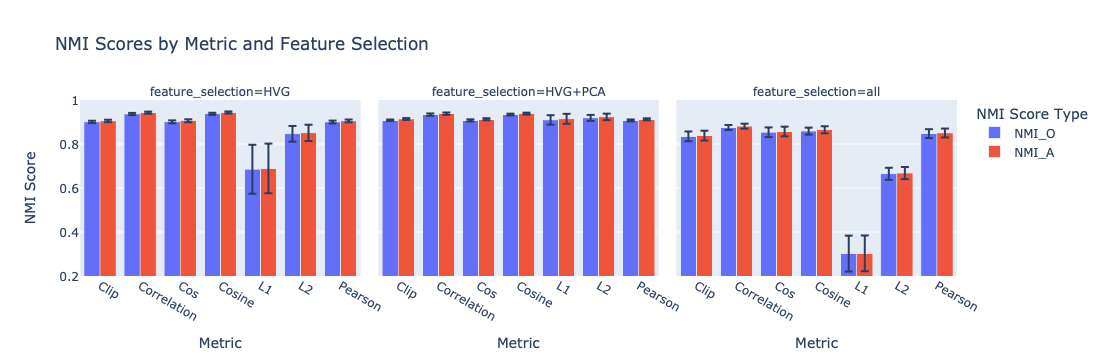

In [27]:
import plotly.express as px
import pandas as pd

# Load your data into 'result' DataFrame
result = pd.read_csv(f"results_0220.csv")

# Normalize metric names
result['metric'] = result['metric'].apply(lambda x: x.capitalize())

# Calculate mean and standard deviation for NMI(O) and NMI(A)
grouped_result = result.groupby(['feature_selection', 'metric'])
mean_std_scores = grouped_result.agg(
    mean_NMI_O=pd.NamedAgg(column='NMI(O)', aggfunc='mean'),
    std_NMI_O=pd.NamedAgg(column='NMI(O)', aggfunc='std'),
    mean_NMI_A=pd.NamedAgg(column='NMI(A)', aggfunc='mean'),
    std_NMI_A=pd.NamedAgg(column='NMI(A)', aggfunc='std')
).reset_index()

# Melt the DataFrame to have separate rows for NMI(O) and NMI(A)
melted_scores = pd.melt(mean_std_scores, 
                        id_vars=['feature_selection', 'metric'], 
                        value_vars=['mean_NMI_O', 'std_NMI_O', 'mean_NMI_A', 'std_NMI_A'],
                        var_name='score_type', 
                        value_name='value')

# Separate the score type and error type into different columns
melted_scores['NMI_type'] = melted_scores['score_type'].apply(lambda x: x.split('_')[1] + '_' + x.split('_')[2])
melted_scores['error_type'] = melted_scores['score_type'].apply(lambda x: 'error' if 'std' in x else 'mean')

# Filter out rows corresponding to mean scores for plotting
mean_scores = melted_scores[melted_scores['error_type'] == 'mean']

# Filter out rows corresponding to std scores to use as error bars
error_scores = melted_scores[melted_scores['error_type'] == 'error']

# Create an interactive bar chart
fig = px.bar(
    mean_scores,
    x='metric',
    y='value',
    error_y=error_scores['value'].values,
    color='NMI_type',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Scores by Metric and Feature Selection',
    labels={'value': 'Mean NMI Score', 'metric': 'Metric'},
    hover_data=mean_scores.columns.tolist()
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='NMI Score Type',
    yaxis_range=[0.2,1]
)

# Show the figure
fig.show()

  feature_selection  algorithm  metric  mean_NMI   std_NMI  length
5               all  banditpam  cosine  0.199257  0.025762       3
4               all  banditpam    clip  0.200219  0.026891       3
0               HVG  banditpam    clip  0.233597  0.018358       3
1               HVG  banditpam  cosine  0.234875  0.018436       3
2           HVG+PCA  banditpam    clip  0.307597  0.015289       7
3           HVG+PCA  banditpam  cosine  0.323782  0.014405       7


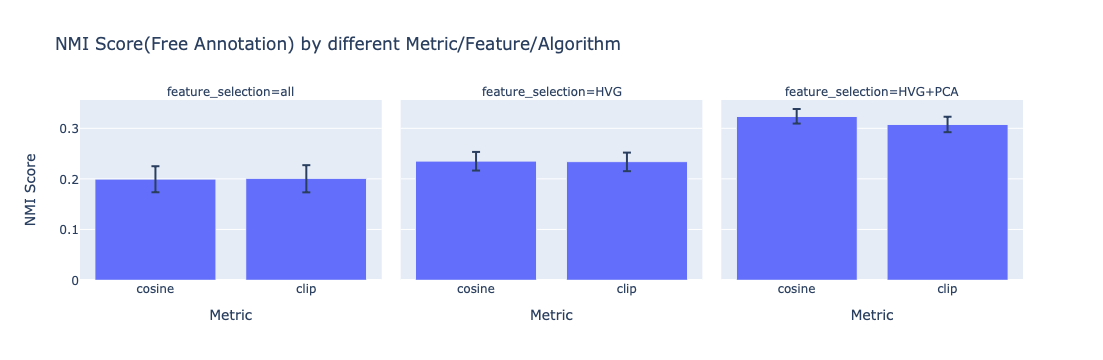

In [13]:
import plotly.express as px
import pandas as pd

# Assuming you have already loaded your data into 'result' DataFrame.
df1 = pd.read_csv(f"results_0229_1.csv")
df2 = pd.read_csv(f"results_0229.csv")
frames = [df1, df2]
result = pd.concat(frames)

result['metric'] = result['metric'].apply(lambda x: 'L1' if x == 'l1' else x)
result['metric'] = result['metric'].apply(lambda x: 'L2' if x == 'l2' else x)
result['metric'] = result['metric'].apply(lambda x: 'cosine' if x == 'cos' else x)
result['metric'] = result['metric'].apply(lambda x: 'pearson' if x == 'correlation' else x)

result = result[result['metric'].isin(['cosine', 'clip'])]
result = result[result['algorithm'] == 'banditpam']

# Calculate mean and standard deviation for each metric and algorithm
mean_scores = result.groupby(['feature_selection', 'algorithm', 'metric'])['NMI'].mean().reset_index(name='mean_NMI')
std_scores = result.groupby(['feature_selection', 'algorithm', 'metric'])['NMI'].std().reset_index(name='std_NMI')

# Merge the mean and standard deviation into one DataFrame
merged_scores = pd.merge(mean_scores, std_scores, on=['feature_selection', 'algorithm', 'metric'])
merged_scores['length'] = mean_scores['feature_selection'].str.len()
merged_scores = merged_scores.sort_values(by = ['length'], ascending= False)
merged_scores = merged_scores.iloc[::-1]
print(merged_scores)

# Create an interactive bar chart
fig = px.bar(
    merged_scores,
    x='metric',
    y='mean_NMI',
    error_y='std_NMI',
    # color='algorithm',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Score(Free Annotation) by different Metric/Feature/Algorithm',
    labels={'mean_NMI': 'Mean NMI', 'std_NMI': 'Standard Deviation', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'std_NMI']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Algorithm',
    # yaxis_range=[0.7,1],
    #     width=1200, height=400
)

# Show the figure
fig.show()

   feature_selection  algorithm   metric  mean_NMI   std_NMI  length
26               all     leiden  pearson  0.881019  0.011440       3
25               all     leiden   cosine  0.864643  0.016104       3
24               all     leiden       L2  0.655517  0.012315       3
23               all     leiden       L1  0.299483  0.083283       3
22               all  banditpam  pearson  0.849963  0.020194       3
21               all  banditpam   cosine  0.856852  0.022118       3
20               all  banditpam     clip  0.838068  0.022383       3
19               all  banditpam       L2  0.680132  0.033891       3
18               all  banditpam       L1  0.306643  0.085697       3
1                HVG  banditpam       L2  0.816955  0.017010       3
3                HVG  banditpam   cosine  0.905510  0.006812       3
4                HVG  banditpam  pearson  0.904759  0.006615       3
6                HVG     leiden       L2  0.884163  0.008486       3
5                HVG     leiden   

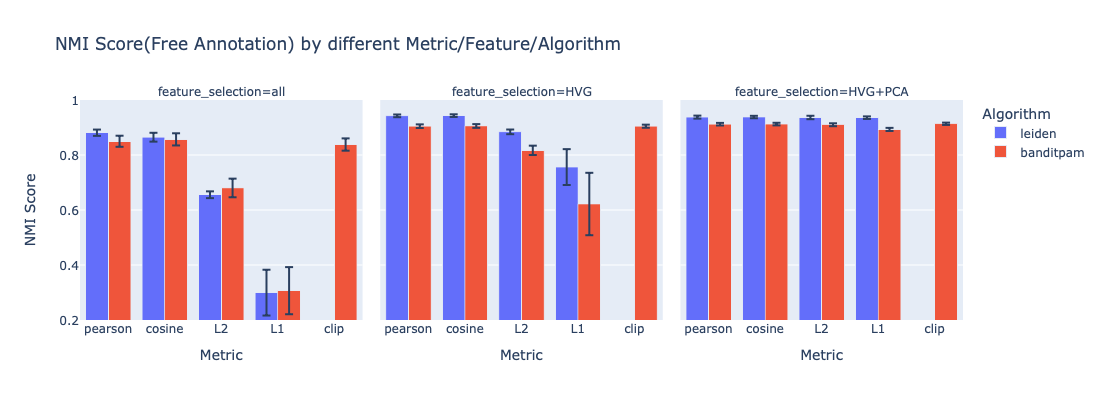

In [34]:
import plotly.express as px
import pandas as pd

# Assuming you have already loaded your data into 'result' DataFrame.
result = pd.read_csv(f"results_0220.csv")

result['metric'] = result['metric'].apply(lambda x: 'L1' if x == 'l1' else x)
result['metric'] = result['metric'].apply(lambda x: 'L2' if x == 'l2' else x)
result['metric'] = result['metric'].apply(lambda x: 'cosine' if x == 'cos' else x)
result['metric'] = result['metric'].apply(lambda x: 'pearson' if x == 'correlation' else x)

# Calculate mean and standard deviation for each metric and algorithm
mean_scores = result.groupby(['feature_selection', 'algorithm', 'metric'])['NMI(A)'].mean().reset_index(name='mean_NMI')
std_scores = result.groupby(['feature_selection', 'algorithm', 'metric'])['NMI(A)'].std().reset_index(name='std_NMI')

# Merge the mean and standard deviation into one DataFrame
merged_scores = pd.merge(mean_scores, std_scores, on=['feature_selection', 'algorithm', 'metric'])
merged_scores['length'] = mean_scores['feature_selection'].str.len()
merged_scores = merged_scores.sort_values(by = ['length'], ascending= False)
merged_scores = merged_scores.iloc[::-1]
print(merged_scores)

# Create an interactive bar chart
fig = px.bar(
    merged_scores,
    x='metric',
    y='mean_NMI',
    error_y='std_NMI',
    color='algorithm',
    facet_col='feature_selection',
    barmode='group',
    title='NMI Score(Free Annotation) by different Metric/Feature/Algorithm',
    labels={'mean_NMI': 'Mean NMI', 'std_NMI': 'Standard Deviation', 'metric': 'Metric'},
    hover_data=['mean_NMI', 'std_NMI']
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Algorithm',
    yaxis_range=[0.2,1],
        width=1200, height=400
)

# Show the figure
fig.show()

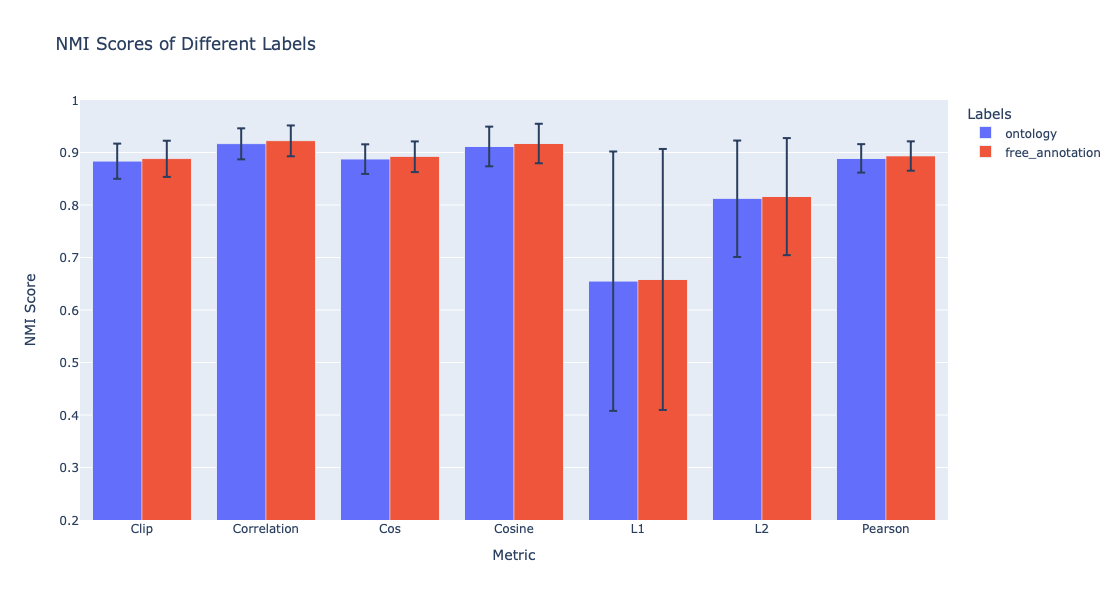

In [35]:
import plotly.express as px
import pandas as pd

# Load your data into 'result' DataFrame
result = pd.read_csv(f"results_0220.csv")

# Normalize metric names
result['metric'] = result['metric'].apply(lambda x: x.capitalize())

# Calculate mean and standard deviation for NMI(O) and NMI(A)
grouped_result = result.groupby([ 'metric'])
mean_std_scores = grouped_result.agg(
    mean_NMI_O=pd.NamedAgg(column='NMI(O)', aggfunc='mean'),
    std_NMI_O=pd.NamedAgg(column='NMI(O)', aggfunc='std'),
    mean_NMI_A=pd.NamedAgg(column='NMI(A)', aggfunc='mean'),
    std_NMI_A=pd.NamedAgg(column='NMI(A)', aggfunc='std')
).reset_index()

# Melt the DataFrame to have separate rows for NMI(O) and NMI(A)
melted_scores = pd.melt(mean_std_scores, 
                        id_vars='metric', 
                        value_vars=['mean_NMI_O', 'std_NMI_O', 'mean_NMI_A', 'std_NMI_A'],
                        var_name='score_type', 
                        value_name='value')

# Separate the score type and error type into different columns

def which_label(c):
    if c == 'O': return 'ontology'
    if c == 'A': return 'free_annotation'
melted_scores['NMI_type'] = melted_scores['score_type'].apply(lambda x: which_label(x.split('_')[2]))
melted_scores['error_type'] = melted_scores['score_type'].apply(lambda x: 'error' if 'std' in x else 'mean')

# Filter out rows corresponding to mean scores for plotting
mean_scores = melted_scores[melted_scores['error_type'] == 'mean']

# Filter out rows corresponding to std scores to use as error bars
error_scores = melted_scores[melted_scores['error_type'] == 'error']

# Create an interactive bar chart
fig = px.bar(
    mean_scores,
    x='metric',
    y='value',
    error_y=error_scores['value'].values,
    color='NMI_type',
    # facet_col='feature_selection',
    barmode='group',
    title='NMI Scores of Different Labels',
    labels={'value': 'Mean NMI Score', 'metric': 'Metric'},
    hover_data=mean_scores.columns.tolist()
)

# Customize the layout
fig.update_layout(
    yaxis_title='NMI Score',
    legend_title_text='Labels',
    yaxis_range=[0.2,1],
    width=1000, height=600
)

# Show the figure
fig.show()

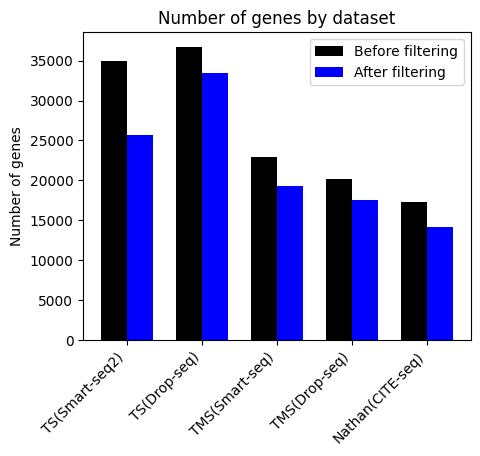

In [5]:
import matplotlib.pyplot as plt
import numpy as np

datasets = ['TS(Smart-seq2)', 'TS(Drop-seq)', 'TMS(Smart-seq)', 'TMS(Drop-seq)', 'Nathan(CITE-seq)']
number_of_genes_before_filtering = [34963, 36715, 22966, 20138, 17256]
number_of_genes_after_filtering = [25655, 33501, 19285, 17563, 14144]

# Update the function to reflect the new data
def chart(datasets, before_filtering, after_filtering):
    # Create a bar chart
    fig, ax = plt.subplots(figsize=(5, 4))

    # Setting the positions and width for the bars
    positions = np.arange(len(datasets))
    width = 0.35  # the width of the bars

    # Plotting before filtering bars in yellow
    bars_before = ax.bar(positions - width/2, before_filtering, width, label='Before filtering', color='black')

    # Plotting after filtering bars in blue
    bars_after = ax.bar(positions + width/2, after_filtering, width, label='After filtering', color='blue')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of genes')
    ax.set_title('Number of genes by dataset')
    ax.set_xticks(positions)
    ax.set_xticklabels(datasets, rotation=45, ha='right')
    ax.legend()

    # A function to show the plot
    plt.show()

# Call the function with the corrected data to generate the graph.
chart(datasets, number_of_genes_before_filtering, number_of_genes_after_filtering)